## Introduction

A general idea for pose synchronicity estimation is to calculate delay between matching _motion events_ for each pose.
One of the natural motion events to consider is the turning point of a limb - the moment when the angular acceleration of a limb is 0. For example, imagine someone waving 'hello' (for the sake of example - in a perfectly symmetrical way). Turning points of a forearm for this motion would be the ones when it passes through a vertical position. The temporal spacing between such turning points corresponds directly to the rythm of motion (imagine rhythmometer for example) making them the first candidates for pose synchronicity events. However, these turning points correspond to zeroes of the angular acceleration of a limb which is, essentially, a second derivative of an angle as a function of time. As in practice the function `angle(time)` is an approximation of the noisy data the location of its second derivative roots is very sensitive to the approximation method (in particular &ndash; to the smoothing performed). Hence instead of using turning points 'stationary points' (when angular velocity is 0) can be used as motion events. In the "waving hand" example described above such points correspond to moments when the forearm is in its left- or rightmost position.

An overall algorithm for pose synchronicity estimation using stationary points as motion events is as follows:

1. For two bodies that are to be compared angular limb motion should be determined
2. For each pair of corresponding limbs that are present in both bodies delay between the extracted 'stationary points' should be estimated
3. An overal pose synchronisity is defined as the average (or median) of all the obtained delays

Details of each stage are described below.

In [1]:
# but first of all - package import

import matplotlib.pyplot as plt
import numpy as np
import math
import os

from tqdm import tqdm
import cv2
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter1d

import vidutils

## 1. The definition of motion

To define body motion the body itself should be defined. Well, a `body` can be seen as a set of limbs. A `limb` itself can be represented by a line segment or, more precisely, by two points on a plane. An `angle` for a given `limb` can be defined as the angle between the limb and a vertical line, for example like this:

&nbsp;  

&nbsp;  
&nbsp;  

which is the result given by a common formula `atan2(dp.x, dp.y)` where `dp = p0 - p1` (openpose itself uses it when drawing skeleton). However, this mapping from `dp` components to angle is discontinuous around the transition point $-\pi \rightarrow \pi$ (shown as a red line). This discontinuity may cause (and in practice does cause) discontinuities in apparent angular motion which messes up the differentiation. But as we are interested not in the value of the angle itself but only in angular velocity we can use the current mapping instead: `atan2(abs(dp.x), dp.y)`. This mapping is continuous and symmetrical along the vertical line:

&nbsp;  

&nbsp;  
&nbsp;  

It should be noted that the `body` defined above captures body pose only at one instant of time. To represent motion an array of bodies can be used but it is not very convenient as we are interested in each `limb` angle as a function of time. To capture the time-varying nature of bodies let's define another class `dancer`. Internally it will contain a similar set of limbs as `body` but in `dancer` each limb will be represented by its angular trajectory:

In [2]:
class limb:

    # `p0` and `p1` are of the form `np.array([x, y])`
    def __init__(this, p0, p1):
        this.p0 = p0
        this.p1 = p1

    # angle between the limb and the vertical line (in radians)
    def angle(this):
        dp = this.p0 - this.p1
        return math.atan2(abs(dp[0]), dp[1])


class body:

    """
    # class members:

    root:  point    # is used only for sorting different bodies in space (point(x, y) is np.array([x, y]))
    limbs: dict     # mapping {limb_name -> limb_instance}

    """

    # `current_subset` is an element of `subset` for current body;
    # `candidate` is a full list of keypoints returned by `body_estimation`;
    #
    # note: if `current_subset` and/or `candidate` is None the created `body` is 'empty':
    #       `limbs` will contain every limb name but all of them will map to `None`
    #
    def __init__(this, candidate = None, current_subset = None):

        #helper functions
        
        # index `idx` represents a keypoint in `current_subset`;
        # returns an array of the form `[x, y]`
        #
        # note: if the keypoint refered to by `idx` is absent
        #       returns `None`
        #
        def get_point_by_index(idx):

            if current_subset is not None and candidate is not None:

                # remapping 'index of a keypoint' -> 'index of the corresponding keypoint coordinates'
                idx = int(current_subset[idx])

                if idx == -1:
                    return None
                else:
                    return candidate[idx][0:2]
            else:
                return None

        # returns a `limb` constructed using points refered by keypoint indices `idx1` and `idx2`:
        # 
        #  -> limb(p1, p2)
        #
        #  where:
        #         `p1` and `p2` are of the form `[x, y]` and denote a keypoint position
        #
        #  note: if any of the keypoints refered to by `idx1` or `idx2` is absent
        #        returns `None`
        #
        def create_limb(idx1, idx2):
           
            p1 = get_point_by_index(idx1)
            p2 = get_point_by_index(idx2)

            if p1 is None or p2 is None:
                return None
            else:
                return limb(p1, p2)

        #------------------------------------------------------------------------

        # the body root is assumed to be the keypoint 1 (bottom of the neck)
        this.root = get_point_by_index(1)

        this.limbs = \
        {
            'neck':           create_limb(1,  0),

            'right_shoulder': create_limb(1,  2),
            'right_forearm':  create_limb(2,  3),
            'right_arm':      create_limb(3,  4),
            'right_thigh':    create_limb(8,  9),
            'right_leg':      create_limb(9,  10),

            'left_shoulder':  create_limb(1,  5),
            'left_forearm':   create_limb(5,  6),
            'left_arm':       create_limb(6,  7),
            'left_thigh':     create_limb(11, 12),
            'left_leg':       create_limb(12, 13)
        }

    # operator[](limb_name) -> limb
    def __getitem__(this, limb_name):
        return this.limbs[limb_name]


class dancer:

    """
    # class members:

    limbs: dict     # mapping {limb_name -> angle(time)}

    """

    # `body_instances` is an array of different time instances of `body` for a particular dancer
    #
    # `timeline` is an array containing time moment for each element of `body_instances`;
    # (`timeline` and `body_instances` are required to have the same length)
    #
    # note: if no `timeline` is present it is created as a range(len(`body_instances`))
    #
    def __init__(this, body_instances, timeline = None):

        this.limbs = {}

        if len(body_instances) > 0:

            if timeline is None:
                timeline = range(len(body_instances))

            # initilizing `this.limbs`
            for limb_name in body_instances[0].limbs:
                this.limbs[limb_name] = []

            # collecting all the angles for each limb throughout all the instances
            for k in range(len(body_instances)):
                for limb_name in body_instances[k].limbs:

                    # selected limb for a current body instance
                    l = body_instances[k].limbs[limb_name]

                    # some instances may lack a limb `limb_name`
                    if l is not None:
                        this.limbs[limb_name].append((timeline[k], l.angle()))
                #end
            #end

            # at this point `this.limbs` is a mapping
            # from `limb_name` to a list of tuples of the form (t, angle_of_`limb_name`_at_moment_t)

            # now converting each array of points into an interpolation function:
            #
            for limb_name in this.limbs:

                p = this.limbs[limb_name]
                
                if len(p) > 0:
                    # first, check that `p` contains endpoints;
                    # otherwise extrapolation should be used
                    # but the data is not enough for more or less 'correct' extrapolation
                    #
                    if p[0][0] == timeline[0] and p[-1][0] == timeline[-1]:
                        
                        # unpacking
                        x, y = zip(*p)

                        # smoothing
                        y = gaussian_filter1d(y, 0.018*len(y))

                        # creating approximation
                        this.limbs[limb_name] = interpolate.CubicSpline(x, y)

                    else:
                        # not enough data to approximate
                        this.limbs[limb_name] = None
                else:
                    # no data to approximate;
                    # not erasing the element though so that each `dancer` has
                    # the same set of limbs, some of them just can be 'undefined'
                    # (this will simplify different dancers comparison)
                    #
                    this.limbs[limb_name] = None

                #endif
            #end
        #endif

    # operator[](limb_name) -> spline
    def __getitem__(this, limb_name):
        return this.limbs[limb_name]


A helper function for convenient creation of `dancer` instances:

In [3]:
# creates an array of `dancer` objects from `n_frames` frames in `frames_dir` directory
#
# arguments:
#
#    `body_estimation`     - a body estimation model
#    `frames_dir`          - path to a directory to load frames from
#    `n_frames`            - amount of frames to load
#    `frame_name_template` - a function used for creating sequential frame names;
#                            this function is fed with values from range 0..n_frames-1
#
# return value:
#
#    an array of `dancer` objects for each dancer detected on the frames
#
def create_dancers_from_frames(body_estimation, frames_dir, n_frames, \
                               frame_name_template = lambda idx: 'frame' + str(idx) + '.jpg'):

    frames_dir = os.path.normpath(frames_dir) + os.sep
    
    # list of arrays of body instances:
    #
    #   bodies[k] - array of all the body instances for k-th dancer from the left
    #
    bodies = []

    for i in tqdm(range(n_frames)):

        img = cv2.imread(frames_dir + frame_name_template(i))
        candidate, subset = body_estimation(img)
        
        # creating bodies:

        res = []

        # iterating over all the detected bodies
        for n in range(len(subset)):
            res.append(body(candidate, subset[n]))

        # sorting bodies by horizontal position of the root;
        # if `body.root` is `None` substituting 0 as its horizontal position
        #
        res.sort(key = lambda b: 0 if b.root is None else b.root[0])

        # appending body instances:
        #
        # note: assuming that the number of bodies at each frame is the same!
        #
        for n in range(len(res)):

            while n >= len(bodies):
                # initialize an array of instances for n-th body
                bodies.append([])

            bodies[n].append(res[n])

        #end
    #end

    # reading timeline (if present)

    try:

        # if file exists -> loading
        timeline = np.load(frames_dir + 'timeline.npz')['timeline']

        if len(timeline) < n_frames:

            # invalid timeline
            timeline = None
            
            print("The loaded timeline is inconsistent with the number of loaded frames")

        elif len(timeline) > n_frames:
            
            # too long timeline -> cutting
            timeline = timeline[0:n_frames]

            print("The loaded timeline is longer than the number of loaded frames. Cutting the timeline")

    except:
        timeline = None

    # creating dancers

    dancers = []

    for k in range(len(bodies)):
        dancers.append(dancer(bodies[k], timeline))

    return dancers


## 2. Per-limb delay estimation

To define delay for each limb between two dancers we should first locate the stationary points. Let's have a look:

In [4]:
# at first, let's extract some frames (it turned out that 20 frames is a bit too little)
#
vidutils.extract_frames('videos/video_group7/seg11.mp4', 'sync_measure_data/frames/video_group7/seg11', 40)

# creating dancers
dancers = create_dancers_from_frames(vidutils.body_estimation, 'sync_measure_data/frames/video_group7/seg11', 40)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [05:55<00:00,  8.88s/it]


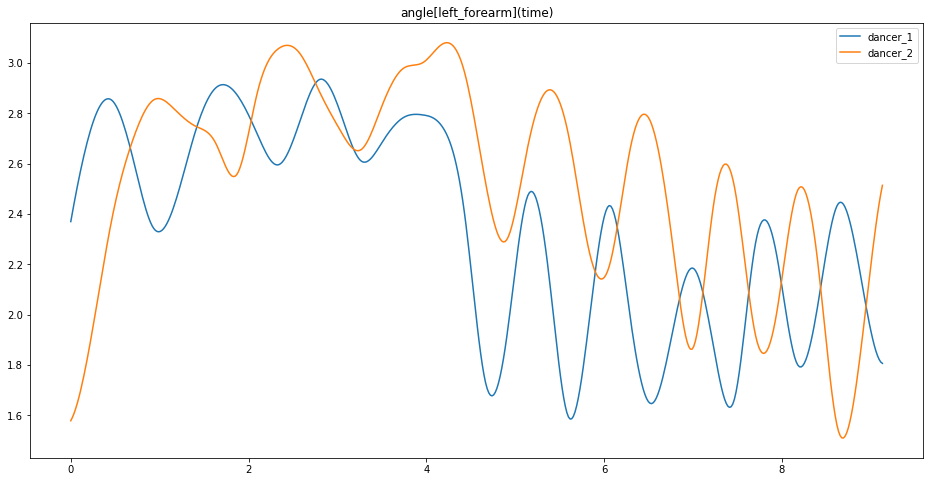

In [5]:
# let's compare two dancers' movement with respect to a certain limb:

limb_name = 'left_forearm'

# first of all, we should determine the timeline boundary;
# different dancers may have had different number of keypoints detected for a selected limb
# but only those limbs retain that were detected both on first and the last frame
# so we can pick any dancer to determine the timeline bounds:
#
x0 = dancers[0][limb_name].x[0]
x1 = dancers[0][limb_name].x[-1]

# dancers to compare:
#
dancer_1 = dancers[0]
dancer_2 = dancers[1]
dancer_3 = dancers[2]

X = np.linspace(x0, x1, 500)

plt.figure(figsize = (16, 8))

plt.plot(X, dancer_1[limb_name](X), X, dancer_2[limb_name](X))

plt.legend(['dancer_1', 'dancer_2'])
plt.title('angle[' + limb_name + '](time)')
plt.show()

&nbsp;  
The plots above look similar but shifted. The amount of this shift is, basically, the delay between dancers with respect to the selected limb. The delay is calculated by time difference between the 'stationary points' (i.e. the extrema). Let's add them to the plot:

extrema_1: [0.42117065 0.98824033 1.71312742 2.32411616 2.81779351 3.30489384
 3.88360143 4.7383651  5.18264878 5.62569673 6.06331133 6.53245435
 6.99286177 7.41556305 7.80624793 8.2112155  8.66258849]


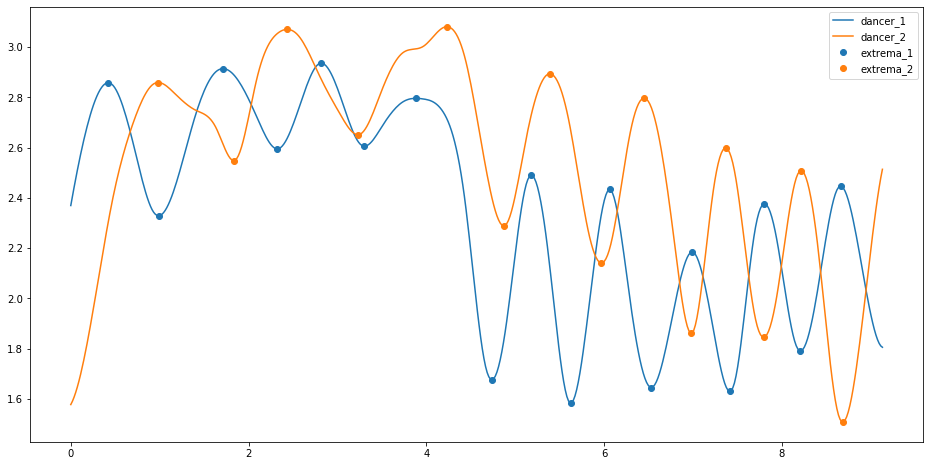

In [6]:
# extrema (aka roots of the derivative) are returned as a list of a function argument values
#
extrema_1 = dancer_1[limb_name].derivative().roots(extrapolate = False)
extrema_2 = dancer_2[limb_name].derivative().roots(extrapolate = False)

print('extrema_1:', extrema_1)

plt.figure(figsize = (16, 8))

p1 = plt.plot(X, dancer_1[limb_name](X))
p2 = plt.plot(X, dancer_2[limb_name](X))

plt.plot(extrema_1, dancer_1[limb_name](extrema_1), 'o', color = p1[0].get_color())
plt.plot(extrema_2, dancer_2[limb_name](extrema_2), 'o', color = p2[0].get_color())

plt.legend(['dancer_1', 'dancer_2', 'extrema_1', 'extrema_2'])
plt.show()

&nbsp;  
Now it seems clear how to compute delay &ndash; one just have to subtract one list from another and take the average of the values. However, there is an issue &ndash; these lists are of unequal length. Moreover, even if they were, there still would have been no guarantee that the extrema are matched. So, we have to find the matching values in the lists first to be able to compare them. The idea is the following &ndash; for each extremum in a smaller list try to find a match from the other such that:
1. matching extrema are both of the same kind (either both maxima or both minima)
2. match should be in a 'relatively close proximity' from the extremum in the first list (if there are several candidates the closest one should be chosen)

The formalization of these criteria results in the following function:

In [7]:
# finds mathing extrema of splines `a` and `b`;
# matching is based on:
#
#  1. extrema proximity
#  2. 'curvature' at extrema
#
def get_matching_extrema(a, b):

    da = a.derivative()
    db = b.derivative()

    extr_a = da.roots(extrapolate = False)
    extr_b = db.roots(extrapolate = False)

    # a rule of thumb is to try to match a smaller set of points
    # to a subset of a larger set of points
    #
    if len(extr_a) <= len(extr_b):
        ref_1 = extr_a
        ref_2 = extr_b

        c_1 = da.derivative()
        c_2 = db.derivative()
        
        swapped = False
    else:
        ref_1 = extr_b
        ref_2 = extr_a
        
        c_1 = db.derivative()
        c_2 = da.derivative()
        
        swapped = True

    # for each extremum `ref_1[k]` (where k = 0..len(ref_1)) try to find a match from `ref_2` such that:
    #
    #   1. the found extremum is in the range (ref_1[k-1]..ref_1[k+1])
    #      (assuming that asynchronicity is less than the interval between 2 melody beats)
    #
    #   2. the found extremum has the same 'curvature' sign as `ref_1[k]`
    #      (i.e. minimum should not be matched to a maximum)
    #
    #   3. if there are several points found satisfying the conditions above
    #      the closest to `ref_1[k]` is taken
    #
    
    extrema_1 = []
    extrema_2 = []
    
    # `ref_2` index
    p = 0
    
    p_min = 0
    
    for k in range(len(ref_1)):

        x0 = -np.inf if k == 0             else ref_1[k-1]
        x1 =  np.inf if k == len(ref_1)-1  else ref_1[k+1]

        # indices of match candidates
        cnd = []

        p = p_min
        while p < len(ref_2):
            
            # extremum too far away -> skipping
            if ref_2[p] < x0:
                p += 1
                continue

            # extremum out of range (x0, x1) -> stop searching
            if ref_2[p] > x1:
                break

            # extremum is in range (x0, x1) -> checking the 2-nd condition:
            #
            if np.sign(c_2(ref_2[p])) == np.sign(c_1(ref_1[k])):
                cnd.append(p)

            p += 1
        #end

        if len(cnd) != 0:

            extrema_1.append(ref_1[k])

            if len(cnd) > 1:
                # sorting candidates by proximity to `ref_1[k]`
                cnd.sort(key = lambda idx: abs(ref_2[idx] - ref_1[k]))

            extrema_2.append(ref_2[cnd[0]])
            p_min = cnd[0]
        #end
    #end

    if swapped:
        # 'unswap'
        return (np.array(extrema_2), np.array(extrema_1))
    else:
        return (np.array(extrema_1), np.array(extrema_2))


Let's test it:

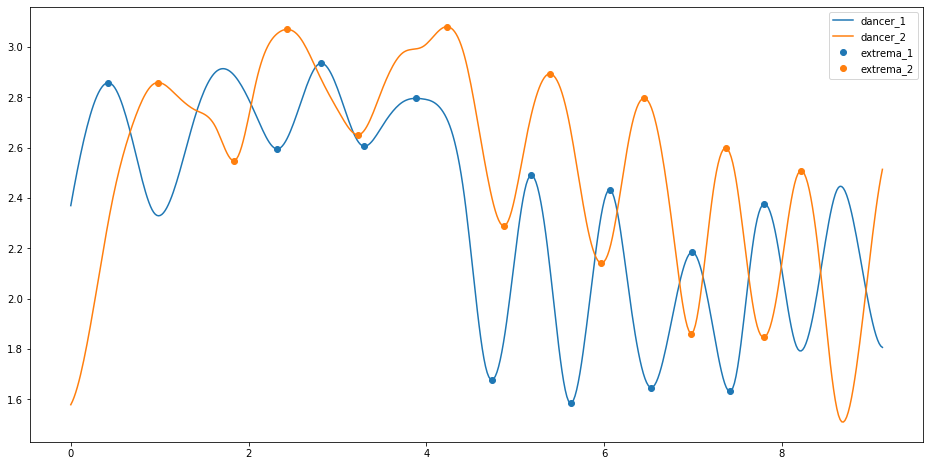

In [8]:
extrema_1, extrema_2 = get_matching_extrema(dancer_1[limb_name], dancer_2[limb_name])

plt.figure(figsize = (16, 8))

p1 = plt.plot(X, dancer_1[limb_name](X))
p2 = plt.plot(X, dancer_2[limb_name](X))

plt.plot(extrema_1, dancer_1[limb_name](extrema_1), 'o', color = p1[0].get_color())
plt.plot(extrema_2, dancer_2[limb_name](extrema_2), 'o', color = p2[0].get_color())

plt.legend(['dancer_1', 'dancer_2', 'extrema_1', 'extrema_2'])
plt.show()

Now both sets of extrema are of equal length and for any `k` `extrema_1[k]` corresponds to `extrema_2[k]`. Now we can subtract them directly and take average to get the delay estimation. However, it should be noted that there are still matching errors or errors in extrema location due to the noise/inconsistency in data so median showed to be more robust than average. You may experiment with different limbs and look how the results change *(note: thighs and legs turned out to be more reliable than arms and forearms)*:

In [9]:
print('Median delay:\t', np.median(extrema_2 - extrema_1), 's')
print('Average delay:\t', np.mean(extrema_2 - extrema_1), 's')

Median delay:	 0.34854732765361973 s
Average delay:	 0.20445769342776826 s


## 3. Pose synchronisity

To estimate the overall pose synchronicity we should, essentially, combine all the per-limb delays:

In [10]:
def estimate_pose_synchronicity(dancer_1, dancer_2):

    delays = []

    print('Per-limb delays:\n')

    # (each dancer `limbs` containes a fixed set of limb names)
    for limb_name in dancer_1.limbs:

        # if `limb_name` is present in both dancers...
        if dancer_1[limb_name] is not None and dancer_2[limb_name] is not None:

            # ...calculate the corresponding delay
            extrema_1, extrema_2 = get_matching_extrema(dancer_1[limb_name], dancer_2[limb_name])

            dt = np.median(extrema_2 - extrema_1)
            delays.append(dt)

            print('\t', limb_name, ':\t', 1000*dt, ' ms', sep = '')
        #end
    #end

    delays = np.array(delays)

    print('\nOverall delay:\n')

    print('\t', 'median: \t', 1000*np.median(delays), ' ms', sep='')
    print('\t', 'average: \t', 1000*np.mean(delays), ' ms', sep='')

In [11]:
estimate_pose_synchronicity(dancer_1, dancer_2)

Per-limb delays:

	neck:	54.27898394837216 ms
	right_shoulder:	8.19591444294021 ms
	right_forearm:	39.16129930605283 ms
	right_arm:	-21.066003366944308 ms
	right_thigh:	-17.34970367740374 ms
	left_shoulder:	-93.38502937986748 ms
	left_forearm:	348.54732765361973 ms
	left_arm:	-108.16008630842822 ms
	left_thigh:	23.09960343456252 ms

Overall delay:

	median: 	8.19591444294021 ms
	average: 	25.92470067254486 ms


In [12]:
estimate_pose_synchronicity(dancer_1, dancer_3)

Per-limb delays:


Overall delay:

	median: 	nan ms
	average: 	nan ms


D:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Anaconda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [13]:
estimate_pose_synchronicity(dancer_2, dancer_3)

Per-limb delays:


Overall delay:

	median: 	nan ms
	average: 	nan ms
